In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import pickle
import shutil
import os

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

c:\Users\digit\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 27
N_FOLDS = 10
TARGET = 'Target'

In [3]:
train = pd.read_csv(r'D:\공부\포트폴리오\Kaggle\Classification with an Academic Success\train.csv', index_col='id')
test = pd.read_csv(r'D:\공부\포트폴리오\Kaggle\Classification with an Academic Success\test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [4]:
# Reference: https://www.kaggle.com/code/ambrosm/pss4e6-eda-which-makes-sense
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]


for col in cat_features:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [5]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')

        rskf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)

        accs = []
        aucs = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        oof_preds = np.zeros(X.shape[0])
        for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)

            y_pred_probs = model.predict_proba(X_val)
            y_pred = np.argmax(y_pred_probs, axis=1)

            oof_pred_probs[val_idx] = y_pred_probs
            oof_preds[val_idx] = y_pred

            acc = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovo')
            accs.append(acc)
            aucs.append(auc)

            print(f'--- Fold {fold_idx + 1} - Accuracy: {acc:.6f}, AUC: {auc:.6f}')

        print(f'\n------ Accuracy: {np.mean(accs):.6f} ± {np.std(accs):.6f}')
        print(f'------ AUC:      {np.mean(aucs):.6f} ± {np.std(aucs):.6f}\n\n')

        return oof_pred_probs, oof_preds, accs, aucs
    
    def fit_predict_proba(self, X, y, X_test):            
        model = clone(self.model)
        model.fit(X, y)
        return model.predict_proba(X_test)

In [10]:
xgb_params = {
    'n_jobs': -1,
    'max_bin': 86,
    'verbosity': 0,
    'max_depth': 5,
    'max_leaves': 64,
    'booster': 'gbtree',
    'n_estimators': 1539,
    'random_state': SEED,
    'enable_categorical': True,
    'gamma': 0.9069384135972282,
    'reg_alpha': 9.076826031603096,
    'subsample': 0.9335856723937552,
    'reg_lambda': 3.7191495119106976,
    'max_delta_step': 1.1802158903460869,
    'min_child_weight': 8.745168792677534,
    'colsample_bynode': 0.8390631221126779,
    'colsample_bytree': 0.5534666374509267,
    'colsample_bylevel': 0.5695267422612745,
}

cb_params = {
    'depth': 9,
    'verbose': False,
    'thread_count': -1,
    'iterations': 1830,
    'border_count': 200,
    'random_state': SEED,
    'min_child_samples': 4,
    'bootstrap_type': 'MVS',
    'grow_policy': 'Depthwise',
    'random_strength': 0.16489500172653238,
    'colsample_bylevel': 0.45740812601887504,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 77,
    'num_leaves': 42,
    'subsample_freq': 8,
    'n_estimators': 169,
    'random_state': SEED,
    'min_child_samples': 199,
    'subsample': 0.9178993412905838,
    'min_child_weight': 0.4410010971781976,
    'colsample_bytree': 0.35379935570036725,
}

hgb_params = {
    'verbose': 0,
    'max_depth': 4,
    'max_bins': 250,
    'max_iter': 1522,
    'max_leaf_nodes': 92,
    'random_state': SEED,
    'min_samples_leaf': 44,
    'l2_regularization': 0.4495943539321024,
}

gb_params = {
    "learning_rate": 0.03723266557925465,
    "max_depth": 24,
    "max_features": 0.6266103788107601,
    "max_leaf_nodes": 67,
    "min_impurity_decrease": 0.021507241003024057,
    "min_samples_leaf": 0.0029046797466403635,
    "min_samples_split": 0.29296996770068356,
    "n_estimators": 2546,
    "random_state": SEED,
    "subsample": 0.8497194158610936,
    "verbose": 0
}

rf_params = {
    'verbose': 0,
    'max_depth': None,
    'n_estimators': 1200,
    'random_state': SEED,
}

In [11]:
accuracies = {}
aucs = {}

test_pred_probs = {}
oof_pred_probs = {}
oof_preds = {}

In [12]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
xgb_oof_pred_probs, xgb_oof_preds, xgb_accs, xgb_aucs = xgb_trainer.fit(X, y)
oof_pred_probs['XGB'] = xgb_oof_pred_probs
oof_preds['XGB'] = xgb_oof_preds
test_pred_probs['XGB'] = xgb_trainer.fit_predict_proba(X, y, test)
accuracies['XGB'] = xgb_accs
aucs['XGB'] = xgb_aucs

Training XGBClassifier
--- Fold 1 - Accuracy: 0.836383, AUC: 0.931732
--- Fold 2 - Accuracy: 0.834422, AUC: 0.930039
--- Fold 3 - Accuracy: 0.837036, AUC: 0.936105
--- Fold 4 - Accuracy: 0.836121, AUC: 0.929253
--- Fold 5 - Accuracy: 0.835599, AUC: 0.930305
--- Fold 6 - Accuracy: 0.832854, AUC: 0.929329
--- Fold 7 - Accuracy: 0.833508, AUC: 0.930647
--- Fold 8 - Accuracy: 0.837951, AUC: 0.929156
--- Fold 9 - Accuracy: 0.821592, AUC: 0.921947
--- Fold 10 - Accuracy: 0.828258, AUC: 0.926619

------ Accuracy: 0.833372 ± 0.004715
------ AUC:      0.929513 ± 0.003412




In [13]:
cb_model = CatBoostClassifier(**cb_params, cat_features=cat_features)
cb_trainer = Trainer(cb_model)
cb_oof_pred_probs, cb_oof_preds, cb_accs, cb_aucs = cb_trainer.fit(X, y)
oof_pred_probs['CB'] = cb_oof_pred_probs
oof_preds['CB'] = cb_oof_preds
test_pred_probs['CB'] = cb_trainer.fit_predict_proba(X, y, test)
accuracies['CB'] = cb_accs
aucs['CB'] = cb_aucs

Training CatBoostClassifier
--- Fold 1 - Accuracy: 0.837820, AUC: 0.930327
--- Fold 2 - Accuracy: 0.832331, AUC: 0.927660
--- Fold 3 - Accuracy: 0.839127, AUC: 0.934861
--- Fold 4 - Accuracy: 0.834161, AUC: 0.928528
--- Fold 5 - Accuracy: 0.837559, AUC: 0.929074
--- Fold 6 - Accuracy: 0.831678, AUC: 0.928947
--- Fold 7 - Accuracy: 0.831025, AUC: 0.929298
--- Fold 8 - Accuracy: 0.832331, AUC: 0.927443
--- Fold 9 - Accuracy: 0.822245, AUC: 0.921133
--- Fold 10 - Accuracy: 0.828519, AUC: 0.925858

------ Accuracy: 0.832680 ± 0.004735
------ AUC:      0.928313 ± 0.003281




In [14]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
lgbm_oof_pred_probs, lgbm_oof_preds, lgbm_accs, lgbm_aucs = lgbm_trainer.fit(X, y)
oof_pred_probs['LGBM'] = lgbm_oof_pred_probs
oof_preds['LGBM'] = lgbm_oof_preds
test_pred_probs['LGBM'] = lgbm_trainer.fit_predict_proba(X, y, test)
accuracies['LGBM'] = lgbm_accs
aucs['LGBM'] = lgbm_aucs

Training LGBMClassifier
--- Fold 1 - Accuracy: 0.835860, AUC: 0.932138
--- Fold 2 - Accuracy: 0.834814, AUC: 0.930214
--- Fold 3 - Accuracy: 0.837689, AUC: 0.936741
--- Fold 4 - Accuracy: 0.835206, AUC: 0.929740
--- Fold 5 - Accuracy: 0.835468, AUC: 0.930482
--- Fold 6 - Accuracy: 0.834945, AUC: 0.929878
--- Fold 7 - Accuracy: 0.833508, AUC: 0.930657
--- Fold 8 - Accuracy: 0.835468, AUC: 0.928880
--- Fold 9 - Accuracy: 0.824337, AUC: 0.922922
--- Fold 10 - Accuracy: 0.829565, AUC: 0.927822

------ Accuracy: 0.833686 ± 0.003697
------ AUC:      0.929947 ± 0.003269




In [15]:
hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_trainer = Trainer(hgb_model)
hgb_oof_pred_probs, hgb_oof_preds, hgb_accs, hgb_aucs = hgb_trainer.fit(X, y)
oof_pred_probs['HGB'] = hgb_oof_pred_probs
oof_preds['HGB'] = hgb_oof_preds
test_pred_probs['HGB'] = hgb_trainer.fit_predict_proba(X, y, test)
accuracies['HGB'] = hgb_accs
aucs['HGB'] = hgb_aucs

Training HistGradientBoostingClassifier
--- Fold 1 - Accuracy: 0.836252, AUC: 0.931161
--- Fold 2 - Accuracy: 0.832201, AUC: 0.929124
--- Fold 3 - Accuracy: 0.836252, AUC: 0.933662
--- Fold 4 - Accuracy: 0.832985, AUC: 0.927908
--- Fold 5 - Accuracy: 0.835206, AUC: 0.928302
--- Fold 6 - Accuracy: 0.833116, AUC: 0.927773
--- Fold 7 - Accuracy: 0.828411, AUC: 0.929311
--- Fold 8 - Accuracy: 0.834422, AUC: 0.928083
--- Fold 9 - Accuracy: 0.823030, AUC: 0.922315
--- Fold 10 - Accuracy: 0.827604, AUC: 0.925947

------ Accuracy: 0.831948 ± 0.004089
------ AUC:      0.928359 ± 0.002836




In [16]:
gb_model = GradientBoostingClassifier(**gb_params)
gb_trainer = Trainer(gb_model)
gb_oof_pred_probs, gb_oof_preds, gb_accs, gb_aucs = gb_trainer.fit(X, y)
oof_pred_probs['GB'] = gb_oof_pred_probs
oof_preds['GB'] = gb_oof_preds
test_pred_probs['GB'] = gb_trainer.fit_predict_proba(X, y, test)
accuracies['GB'] = gb_accs
aucs['GB'] = gb_aucs

Training GradientBoostingClassifier
--- Fold 1 - Accuracy: 0.835337, AUC: 0.931619
--- Fold 2 - Accuracy: 0.837428, AUC: 0.930523
--- Fold 3 - Accuracy: 0.837428, AUC: 0.936066
--- Fold 4 - Accuracy: 0.835337, AUC: 0.929429
--- Fold 5 - Accuracy: 0.837559, AUC: 0.930918
--- Fold 6 - Accuracy: 0.835206, AUC: 0.929631
--- Fold 7 - Accuracy: 0.831417, AUC: 0.930490
--- Fold 8 - Accuracy: 0.835337, AUC: 0.929203
--- Fold 9 - Accuracy: 0.823683, AUC: 0.923081
--- Fold 10 - Accuracy: 0.827996, AUC: 0.927875

------ Accuracy: 0.833673 ± 0.004371
------ AUC:      0.929883 ± 0.003068




In [17]:
rf_model = RandomForestClassifier(**rf_params)
rf_trainer = Trainer(rf_model)
rf_oof_pred_probs, rf_oof_preds, rf_accs, rf_aucs = rf_trainer.fit(X, y)
oof_pred_probs['RF'] = rf_oof_pred_probs
oof_preds['RF'] = rf_oof_preds
test_pred_probs['RF'] = rf_trainer.fit_predict_proba(X, y, test)
accuracies['RF'] = rf_accs
aucs['RF'] = rf_aucs

Training RandomForestClassifier
--- Fold 1 - Accuracy: 0.833116, AUC: 0.924935
--- Fold 2 - Accuracy: 0.828411, AUC: 0.923582
--- Fold 3 - Accuracy: 0.832462, AUC: 0.928687
--- Fold 4 - Accuracy: 0.830633, AUC: 0.922141
--- Fold 5 - Accuracy: 0.830502, AUC: 0.922150
--- Fold 6 - Accuracy: 0.828542, AUC: 0.920969
--- Fold 7 - Accuracy: 0.825666, AUC: 0.924080
--- Fold 8 - Accuracy: 0.828411, AUC: 0.923834
--- Fold 9 - Accuracy: 0.819109, AUC: 0.914856
--- Fold 10 - Accuracy: 0.822507, AUC: 0.921071

------ Accuracy: 0.827936 ± 0.004178
------ AUC:      0.922630 ± 0.003355




In [18]:
def objective(trial):
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 1.0)
    cb_weight = trial.suggest_float('cb_weight', 0.0, 1.0)
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.0, 1.0)
    hgb_weight = trial.suggest_float('hgb_weight', 0.0, 1.0)
    gb_weight = trial.suggest_float('gb_weight', 0.0, 1.0)
    rf_weight = trial.suggest_float('rf_weight', 0.0, 1.0)

    weights = [
        xgb_weight, 
        cb_weight, 
        lgbm_weight, 
        hgb_weight, 
        gb_weight, 
        rf_weight
    ]
    weights /= np.sum(weights)

    pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
    for model, weight in zip(oof_pred_probs.keys(), weights):
        pred_probs += oof_pred_probs[model] * weight

    preds = np.argmax(pred_probs, axis=1)

    return accuracy_score(y, preds)


sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000)

best_weights = study.best_params
best_weights = [best_weights[f'{model}_weight'] for model in ['xgb', 'cb', 'lgbm', 'hgb', 'gb', 'rf']]
best_weights /= np.sum(best_weights)

[I 2024-12-11 08:25:21,342] A new study created in memory with name: no-name-8715da79-120c-416e-a18a-94681cff4677
[I 2024-12-11 08:25:21,412] Trial 0 finished with value: 0.8349800047047753 and parameters: {'xgb_weight': 0.4257214105188958, 'cb_weight': 0.8145837404945526, 'lgbm_weight': 0.7353972901996796, 'hgb_weight': 0.8680031998797357, 'gb_weight': 0.3833807728726202, 'rf_weight': 0.9794566321445206}. Best is trial 0 with value: 0.8349800047047753.
[I 2024-12-11 08:25:21,435] Trial 1 finished with value: 0.8347447659374265 and parameters: {'xgb_weight': 0.8931943467151353, 'cb_weight': 0.20971516975437543, 'lgbm_weight': 0.7418276474127408, 'hgb_weight': 0.6631433191297429, 'gb_weight': 0.8868014614919371, 'rf_weight': 0.8580127121355462}. Best is trial 0 with value: 0.8349800047047753.
[I 2024-12-11 08:25:21,458] Trial 2 finished with value: 0.8348623853211009 and parameters: {'xgb_weight': 0.7492622137435189, 'cb_weight': 0.8701447200552547, 'lgbm_weight': 0.18675584347141305, '

In [19]:
ensemble_oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
for model, weight in zip(oof_pred_probs.keys(), best_weights):
    ensemble_oof_pred_probs += oof_pred_probs[model] * weight

ensemble_oof_preds = np.argmax(ensemble_oof_pred_probs, axis=1)
ensemble_acc = accuracy_score(y, ensemble_oof_preds)
ensemble_auc = roc_auc_score(y, ensemble_oof_pred_probs, multi_class='ovo')

oof_pred_probs['Ensemble'] = ensemble_oof_pred_probs
oof_preds['Ensemble'] = ensemble_oof_preds
accuracies['Ensemble'] = [ensemble_acc] * N_FOLDS
aucs['Ensemble'] = [ensemble_auc] * N_FOLDS

In [20]:
accuracies = pd.DataFrame(accuracies)
aucs = pd.DataFrame(aucs)

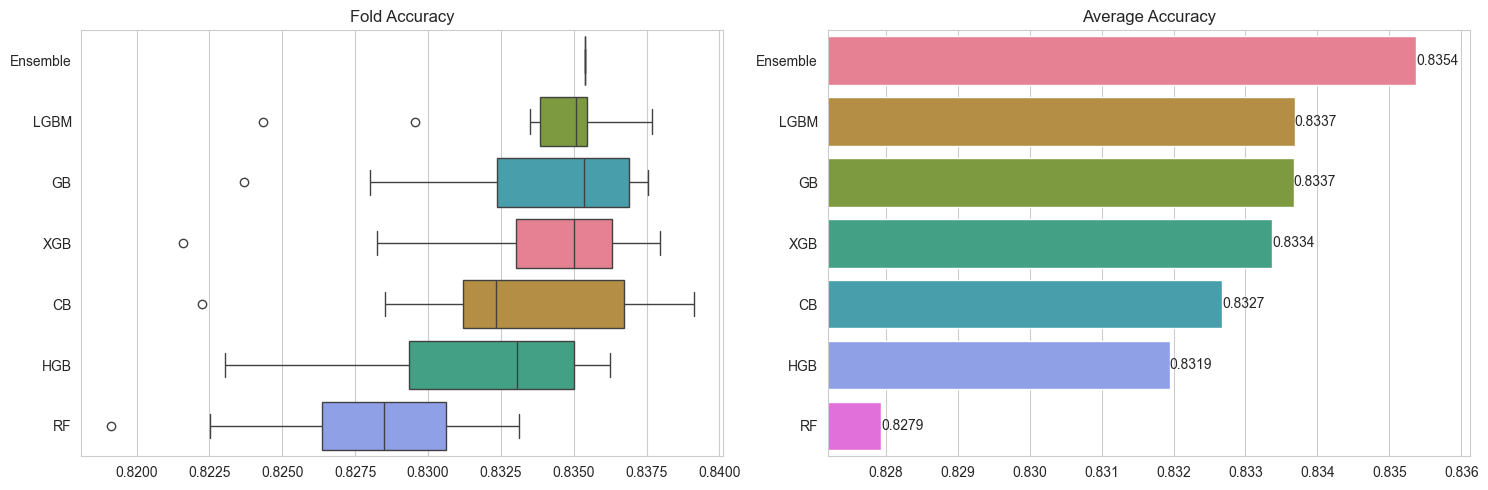

In [21]:
mean_accs = accuracies.mean().sort_values(ascending=False)
order = accuracies.mean().sort_values(ascending=False).index.tolist()

min_acc = mean_accs.min()
max_acc = mean_accs.max()
padding = (max_acc - min_acc) * 0.1
lower_limit = min_acc - padding
upper_limit = max_acc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order,ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_accs.values, y=mean_accs.index,ax=axs[1], palette='husl')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_accs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

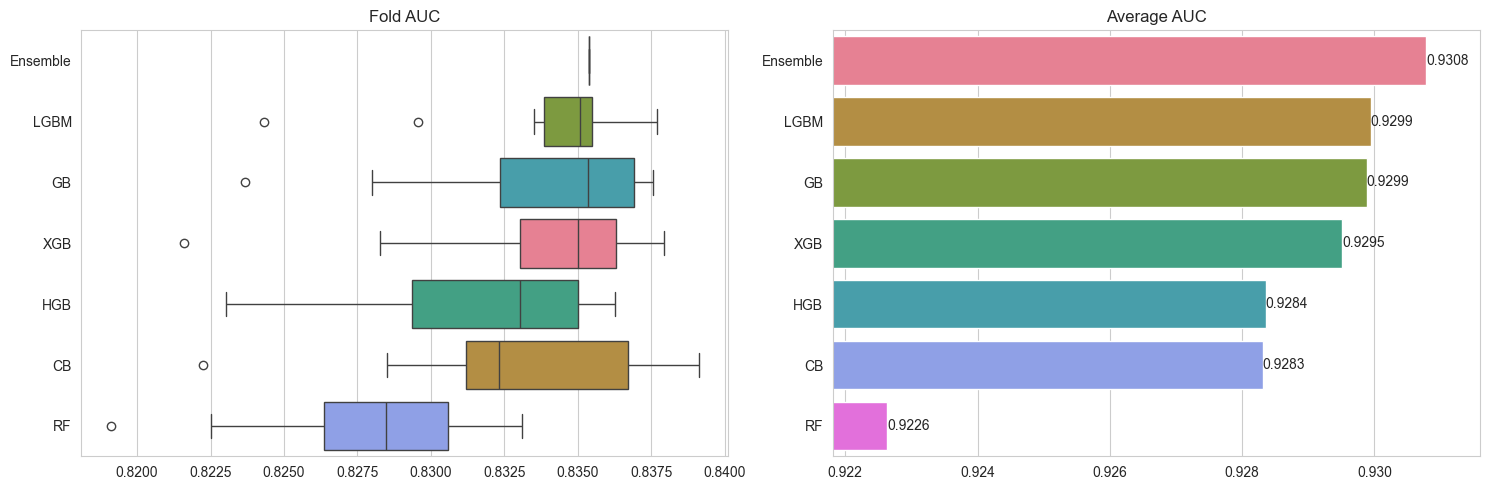

In [22]:
mean_aucs = aucs.mean().sort_values(ascending=False)
order = aucs.mean().sort_values(ascending=False).index.tolist()

min_auc = mean_aucs.min()
max_auc = mean_aucs.max()
padding = (max_auc - min_auc) * 0.1
lower_limit = min_auc - padding
upper_limit = max_auc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order,ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_aucs.values, y=mean_aucs.index,ax=axs[1], palette='husl')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_aucs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

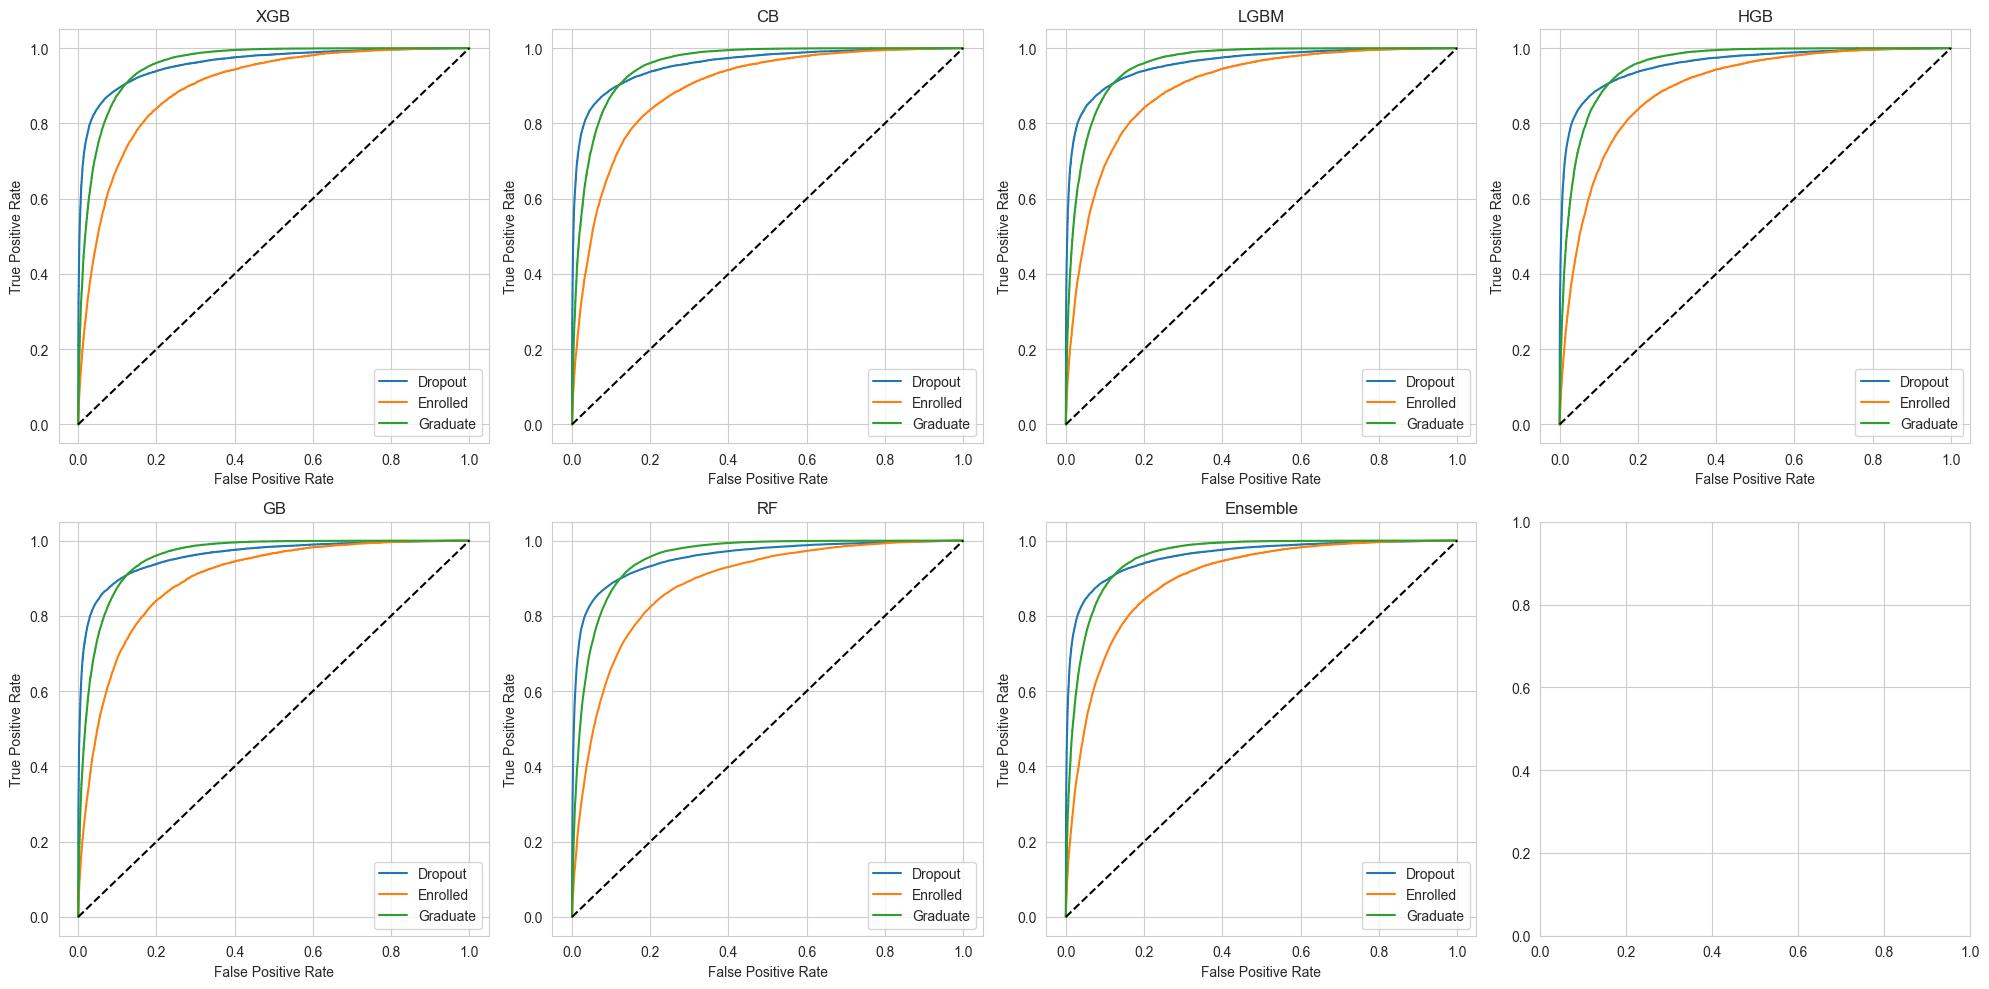

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    for i in range(pred_probs.shape[1]):
        fpr, tpr, _ = roc_curve(y, pred_probs[:, i], pos_label=i)
        ax.plot(fpr, tpr, label=f'{label_encoder.inverse_transform([i])[0]}')

    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_title(model)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.tight_layout()
plt.show()

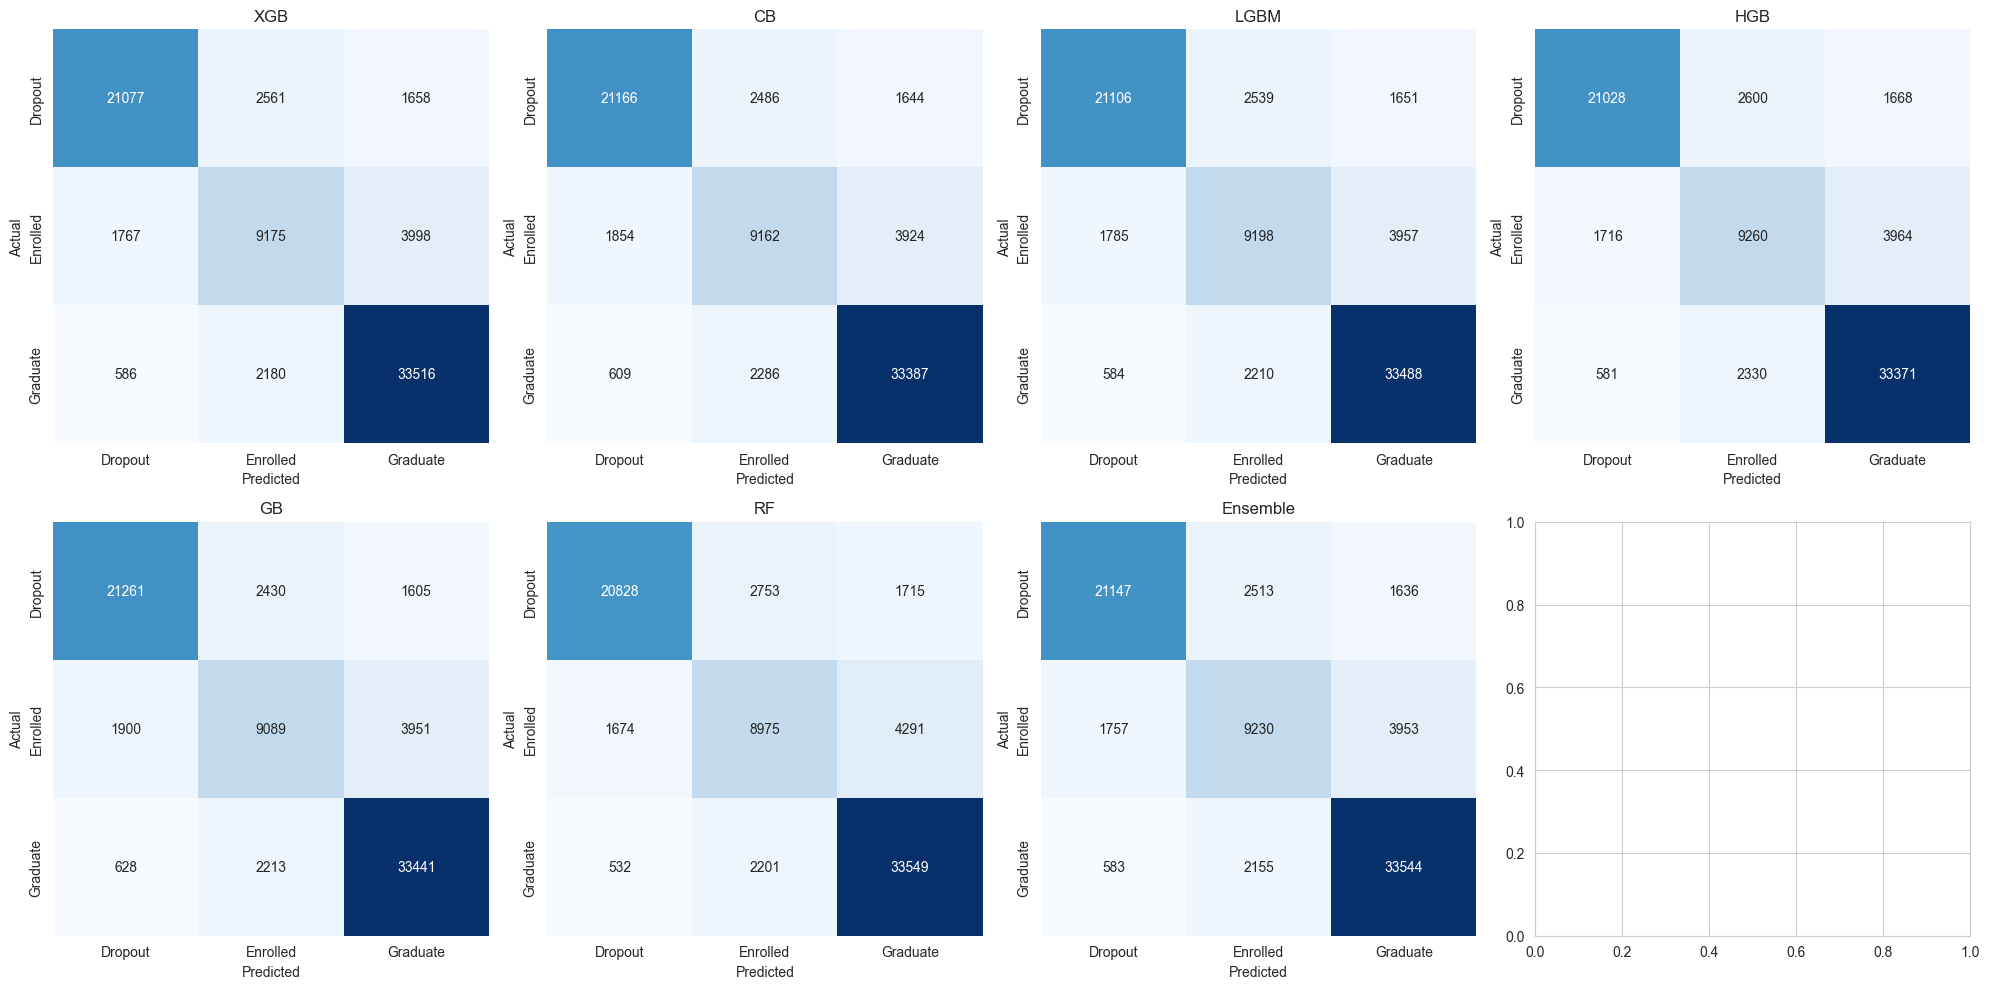

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    y_pred = np.argmax(pred_probs, axis=1)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        cmap='Blues',
        ax=ax, 
        xticklabels=label_encoder.classes_, 
        yticklabels=label_encoder.classes_, 
        cbar=False,
        fmt='d'
    )
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
plt.tight_layout()
plt.show()

In [25]:
final_pred_probs = np.zeros((test.shape[0], len(np.unique(y))))
for model, weight in zip(test_pred_probs.keys(), best_weights):
    final_pred_probs += test_pred_probs[model] * weight
    
final_preds = np.argmax(final_pred_probs, axis=1)
final_preds = label_encoder.inverse_transform(final_preds)

submission = pd.DataFrame({'id': test.index, 'Target': final_preds})
submission.to_csv(f"ensemble_acc-{np.mean(accuracies['Ensemble']):.6f}_auc-{np.mean(aucs['Ensemble']):.6f}.csv", index=False)

In [26]:
os.mkdir('oof_pred_probs')
os.mkdir('test_pred_probs')

for model, pred_probs in oof_pred_probs.items():
    with open(f'oof_pred_probs/{model.lower()}_oof_pred_probs.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)
        
for model, pred_probs in test_pred_probs.items():
    with open(f'test_pred_probs/{model.lower()}_test_pred_probs.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

In [27]:
shutil.rmtree("catboost_info")